# **Image Super Resolution**
The goal of super resolution is to create high resolution images from a low resolution input given an upscale factor. This factor represents how many times bigger the image should become.

## Data Mounting
First the data must be mounted to be used.

In [25]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Module Imports
Then all the necessary files must be imported.

In [26]:
import tensorflow as tf
import numpy as np
import math
from sys import maxsize
import os
from PIL import Image

## Model Design
This is the skeleton of the model designed after the ESPCN SISR model. Look [here](https://github.com/umd-fire-coml/2020-Image-Super-Resolution/blob/master/model.md) for more in-depth info on what this means.

In [27]:
# 6-layer ESPCN SISR model
def espcn_model(r, channels = 3):
    # Arguments for Conv2D
    conv_args = {
      "activation": "relu",
      "padding" : "same",
    }
    # Input
    inputs = keras.Input(shape=(None, None, channels))
    # Feature Maps Extraction
    conv1 = layers.Conv2D(64, 5, **conv_args)(inputs)
    conv2 = layers.Conv2D(64, 3, **conv_args)(conv1)
    conv3 = layers.Conv2D(32, 3, **conv_args)(conv2)
    conv4 = layers.Conv2D(32, 3, **conv_args)(conv3)
    conv5 = layers.Conv2D(32, 3, **conv_args)(conv4)
    conv6 = layers.Conv2D(channels*(r*r), 3, **conv_args)(conv5)
    # Efficient Sub-Pixel Convolutional Layer
    outputs = tf.nn.depth_to_space(conv6, r)
    return Model(inputs, outputs)

## Peak Signal to Noise Ratio
PSNR stands for Peak Signal to Noise Ratio. This is a function that will output the PSNR of two images, which represents the similarity between two images. A higher output represents a more similar image. The minimum value is 0, representing an absolute inverse image while there is no maximum. If two images are identical a special case of -1 is returned as the PSNR would otherwise be undefined (from a divide by zero).

mse represents the mean-squared error. This value essentially is a representation of how far off two images are from each other. For color images, this means the difference between each of the RGB values rather than a single value for grayscale.

There are two definitions as the capital one is used while training and defining the model while the lower case is used to generate a single value for us to see.

In [28]:
# Peak Signal to Noise Ratio
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)


def psnr(oldimg, newimg):
    mse = np.mean((oldimg.astype(float) - newimg.astype(float)) ** 2)
    if mse != 0:
        max_pixel = 1.0
        return 20 * math.log10(max_pixel / math.sqrt(mse))
    else:
        return -1

## Model Loading
Here the upscale factor is defined and the model is compiled and weights are loaded. We have already trained the model and saved the weights so training is not shown here.

In [29]:
r = 3 # Upscale Factor 

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model = espcn_model(r)
model.compile(optimizer=opt, loss='mse', metrics=[PSNR])
model.summary()

# Load pre-trained weights to use
filepath = "/content/drive/Shared drives/COML-STUDENTS-2020/Fall/Team Projects/T4 Image Super-Resolution/r3bs10epochs100weights.h5"
model.load_weights(filepath)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 64)    4864      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, None, None, 32)    9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, None, None, 27)   

## Data Generator
The following code is our data generator. There are several preprocessing methods we use to help train our model. On top of this, we use the data generator to find a pair of low and high resolution image to test our model out with.

In [30]:
# Generates batches of LR and HR pairs
class DataGenerator(Sequence):
    #list_IDs is the images 
    def __init__(self, scale, batch_size, dictionary = "train", shuffle=True):
        'Initialization'
        if dictionary == "test":
          self.images = testing_dict()
        else:
          self.images = training_dict()
        self.scale = scale
        self.r = int(scale[-1])
        self.list_IDs = list(self.images.keys())
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Makes one batch of data'
        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size] 
        list_IDs_temp = [self.list_IDs[k] for k in indexes] 
        # generate data
        X = self.__data_generation(list_IDs_temp)
        return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' 
        LR = []
        HR = []
        min_height_LR = maxsize
        min_width_LR = maxsize
        # Append images as arrays to LR and HR
        for ID in list_IDs_temp:
            low_res = keras.preprocessing.image.load_img(self.images[ID][self.scale])
            high_res = keras.preprocessing.image.load_img(self.images[ID]['original'])
            low_res = np.asarray(low_res)
            high_res = np.asarray(high_res)
            low_res = low_res.astype('float32')
            high_res = high_res.astype('float32')
            # Normalize images to [0,1]
            low_res /= 255.0
            high_res /= 255.0
            LR.append(low_res)
            HR.append(high_res)
            # Find the minimum LR dimensions 
            min_height_LR = min(min_height_LR, low_res.shape[0])
            min_width_LR = min(min_width_LR, low_res.shape[1])
        # HR/SR image is bigger by a factor of r
        min_height_HR = self.r * min_height_LR
        min_width_HR = self.r * min_width_LR
        for i in range (0, len(LR)):
            # Crop LR and HR images to have the same dimensions 
            LR[i] = self.crop_corner(LR[i], min_width_LR, min_height_LR)
            HR[i] = self.crop_corner(HR[i], min_width_HR, min_height_HR)
        LR = np.asarray(LR)
        HR = np.asarray(HR)    
        return LR, HR 
    
    def crop_center(self, img, min_width, min_height):        
        'Crops image around the center given minimum width and height'
        width = img.shape[1]
        height = img.shape[0]
        # Calculates new boundaries around the center
        left = int(np.ceil((width - min_width) / 2))
        right = left + min_width
        top = int(np.ceil((height - min_height) / 2))
        bottom = top + min_height
        # Crop original image
        cropped_img = img[top:bottom, left:right, ...]
        return cropped_img

    def crop_corner(self, img, min_width, min_height):        
        # Crops from top left corner
        cropped_img = img[0:min_height, 0:min_width, ...]
        return cropped_img
# Returns a dictionary containing all classical SR filepaths
def testing_dict():
    data_directory = '/content/drive/Shared drives/COML-STUDENTS-2020/Fall/Team Projects/T4 Image Super-Resolution/data/'
    datasets = ['BSDS100', 'BSDS200', 'General100', 'Set5', 'Set14', 'T91', 'urban100']
    scales = ['LRbicx2', 'LRbicx3', 'LRbicx4']

        # key = image name without directory path
        # value = dict of filepaths of original and scaled images
    images = {}
        # Build images dict for all classical SR images
    for dataset in datasets:
        dataset_directory = data_directory + dataset + '/'
            # Get list of all image names
        image_names = os.listdir(dataset_directory + 'original')
        for image_name in image_names:
                # image_scales dict for storing filepaths of original and scaled images
                # key = scale
                # value = filepath of image
            image_scales = {}
                # original filepath
            image_scales['original'] = dataset_directory + 'original/' + image_name
                # scaled filepaths
            for scale in scales:
                image_scales[scale] = dataset_directory + scale + '/' + image_name
                # image name points to dictionary of scales
            images[image_name] = image_scales
    return images

## Testing
Here is where we get to actually test out our model. We load a random set of standard resolution and high resolution pairs (however our batch_size below is only 1) then we predict what the high resolution should be. After this, we print out the images to compare visually as well as the PSNR to have a numerical assessment of the quality.

Low Resolution: (96, 116, 3)


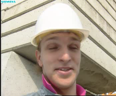

'RGB'

High Resolution: (288, 348, 3)


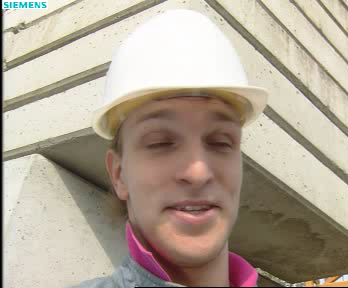

'RGB'

Super Resolution: (288, 348, 3)


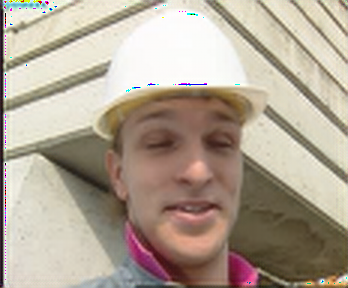

'RGB'

PSNR: 28.072519965183172


In [31]:
testing_generator = DataGenerator('LRbicx' + str(r), batch_size = 1, dictionary = "test")
lr, hr = testing_generator.__getitem__(0)

sr = model.predict(lr)

print("Low Resolution: " + str(lr[0].shape))
display(Image.fromarray((lr[0]*255.0).astype('uint8')), 'RGB')

print("High Resolution: " + str(hr[0].shape))
display(Image.fromarray((hr[0]*255.0).astype('uint8')), 'RGB')

print("Super Resolution: " + str(sr[0].shape))
display(Image.fromarray((sr[0]*255.0).astype('uint8')), 'RGB')

print("PSNR: " + str(psnr(hr[0], sr[0])))

## Results

As you can see, the model does quite well in predicting what the image should become when comparing to the high resolution image (also called the ground truth). However, there are still artifacts and general blurryness produced from this which can be improved by having more time to train the model.